# BusterNet

In [16]:
from warnings import filterwarnings
filterwarnings("ignore")

import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])

## Load Dataset

In [20]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
from pathlib import Path

import cv2
import torch
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import preprocess 

In [21]:
class LeanDataset(Dataset):
    def __init__(self, patch_meta, split_type='train', transform=None):
        self.patch_meta = patch_meta 
        self.split_type = split_type 
        self.transform = transform
        
    def __len__(self): return len(self.patch_meta)
    
    def __getitem__(self, idx):
        img_path, x, y, size, is_forged = self.patch_meta[idx]
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
            if img is None: return torch.zeros((3, size, size)), torch.zeros((1, size, size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            mask = None
            if is_forged:
                m_path = Path(img_path).parents[1] / "masks" / (Path(img_path).stem + ".npy")
                if m_path.exists():
                    mask = np.load(m_path)
                    if mask.ndim == 3: mask = mask[0]
            
            if self.split_type == 'val':
                patch, mask = preprocess.process_val_image(img, mask, size)
            else:
                h, w, _ = img.shape
                y_end, x_end = min(y + size, h), min(x + size, w)
                patch = img[y:y_end, x:x_end]
                if patch.shape[:2] != (size, size):
                    patch = cv2.copyMakeBorder(patch, 0, size-patch.shape[0], 0, size-patch.shape[1], cv2.BORDER_CONSTANT)
                
                if mask is None:
                    mask = np.zeros((size, size), dtype=np.float32)
                else:
                    mask = mask[y:y_end, x:x_end].astype(np.float32)
                    if mask.shape != (size, size):
                        mask = cv2.copyMakeBorder(mask, 0, size-mask.shape[0], 0, size-mask.shape[1], cv2.BORDER_CONSTANT)
            
            if self.transform:
                augmented = self.transform(image=patch, mask=mask if mask is not None else np.zeros((size, size), dtype=np.float32))
                return augmented['image'], augmented['mask'].unsqueeze(0)
            
            return torch.from_numpy(patch).permute(2,0,1).float(), torch.from_numpy(mask).unsqueeze(0)
        except Exception: 
            return torch.zeros((3, size, size)), torch.zeros((1, size, size))

In [22]:
# --- THE PATCH RETRIEVER ---
print("🚀 Starting patch extraction logic...")

base_path = "/Users/chelsymena/recodai-luc-scientific-image-forgery-detection"

train_metadata = preprocess.scan_and_visualize_train(
    root_dir= Path(base_path) / "data_patches", 
    patch_size=512, 
    target_limit=20000,
    )

all_f, all_a = train_metadata['forged'], train_metadata['authentic']

# Validation Lists (Full images)
val_root = Path(base_path) / "data_patches" / "val"
val_f = [(f, 0, 0, 512, True) for f in (val_root / "forged").glob("*")]
val_a = [(f, 0, 0, 512, False) for f in (val_root / "authentic").glob("*")]

# Augmentations
train_trans = A.Compose([A.HorizontalFlip(p=0.5), A.RandomRotate90(p=0.5), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])
val_trans = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])

# Dataloaders
half = 8 // 2
loaders = {
    'train_f': DataLoader(LeanDataset(all_f, 'train', train_trans), batch_size=half, shuffle=True),
    'train_a': DataLoader(LeanDataset(all_a, 'train', train_trans), batch_size=half, shuffle=True),
    'val_f': DataLoader(LeanDataset(val_f, 'val', val_trans), batch_size=half, shuffle=False),
    'val_a': DataLoader(LeanDataset(val_a, 'val', val_trans), batch_size=half, shuffle=False)
}

print(f"✅ Setup Complete! Training on {len(all_f)} Forged / {len(all_a)} Auth patches.")

🚀 Starting patch extraction logic...

🔍 Scanning Train patches (Size: 512)...


Scanning authentic: 100%|██████████| 1901/1901 [00:22<00:00, 84.52it/s] 


📊 TRAIN COUNTS: Forged: 4227, Auth: 3824
✅ Setup Complete! Training on 4227 Forged / 3824 Auth patches.


## Model Architecture

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.optim import AdamW
import csv
from tqdm import tqdm

torch.set_default_dtype(torch.float32)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ResNetBackbone(nn.Module):
    """Extracts multi-scale features from ResNet18"""
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.stem = nn.Sequential(
            base.conv1,
            base.bn1,
            base.relu,
            base.maxpool,
        )
        self.layer1 = base.layer1  # 64 channels, stride 4
        self.layer2 = base.layer2  # 128 channels, stride 8
        self.layer3 = base.layer3  # 256 channels, stride 16
        self.layer4 = base.layer4  # 512 channels, stride 32
    
    def forward(self, x):
        x = self.stem(x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return x4, x3  # Return both for skip connections


class SelfCorrelation(nn.Module):
    """Computes self-correlation to detect copy-move forgery"""
    def __init__(self, channels):
        super().__init__()
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        # Project features
        x = self.proj(x)
        x = x.view(B, C, H * W)
        x = F.normalize(x, dim=1)
        
        # Compute correlation matrix [B, HW, HW]
        corr = torch.bmm(x.transpose(1, 2), x)
        
        # Mask out self-correlation (diagonal)
        eye_mask = torch.eye(H * W, device=x.device, dtype=torch.bool).unsqueeze(0)
        corr = corr.masked_fill(eye_mask, -1e9)
        
        # Get max correlation for each pixel (indicates copy-move)
        corr_max, _ = corr.max(dim=-1)  # [B, HW]
        corr_max = corr_max.view(B, 1, H, W)
        
        return corr_max  # [B, 1, H, W]


class FusionDecoder(nn.Module):
    """Decodes fused features to forgery mask with skip connections"""
    def __init__(self, in_channels, skip_channels=256):
        super().__init__()
        
        # Initial fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(in_channels, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        # Upsample block 1: 512 -> 256 channels, 2x resolution
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        # Process skip connection
        self.skip_conv = nn.Sequential(
            nn.Conv2d(skip_channels, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        # Upsample block 2: 256 -> 128 channels
        self.up2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        # Final prediction head
        self.head = nn.Conv2d(64, 1, kernel_size=1)
    
    def forward(self, x, skip=None):
        # Fuse features
        x = self.fusion(x)
        
        # Upsample and add skip connection
        x = self.up1(x)
        if skip is not None:
            skip = self.skip_conv(skip)
            x = x + skip
        
        # Further processing
        x = self.up2(x)
        
        # Final prediction (logits, no sigmoid)
        x = self.head(x)
        
        return x


class BusterNet(nn.Module):
    """
    Two-stream network for image forgery detection:
    - Artifact stream: detects compression artifacts, noise inconsistencies
    - Similarity stream: detects copy-move forgery via self-correlation
    """
    def __init__(self):
        super().__init__()
        
        # Two backbone streams
        self.backbone_artifact = ResNetBackbone()
        self.backbone_similarity = ResNetBackbone()
        
        # Self-correlation for copy-move detection
        self.correlation = SelfCorrelation(512)
        
        # Decoder with skip connections
        self.decoder = FusionDecoder(
            in_channels=512 + 512 + 1,  # fa + fs + corr
            skip_channels=256  # from layer3
        )
    
    def forward(self, x):
        # Extract features from both streams
        fa, fa_skip = self.backbone_artifact(x)      # Artifact features
        fs, fs_skip = self.backbone_similarity(x)    # Similarity features
        
        # Compute self-correlation from similarity stream
        corr = self.correlation(fs)
        
        # Fuse all features
        fused = torch.cat([fa, fs, corr], dim=1)
        
        # Decode to mask (using skip from artifact stream)
        out = self.decoder(fused, skip=fa_skip)
        
        # Upsample to input resolution
        out = F.interpolate(
            out,
            size=x.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        
        return out  # Return logits (no sigmoid)


def weighted_bce_with_logits(pred, target, pos_weight=10.0):
    """
    Numerically stable weighted BCE loss
    
    Args:
        pred: Model output logits [B, 1, H, W]
        target: Ground truth masks [B, 1, H, W]
        pos_weight: Weight for positive class (forgery pixels)
    """
    # Use built-in weighted BCE with logits for numerical stability
    pos_weight_tensor = torch.tensor([pos_weight], device=pred.device)
    loss = F.binary_cross_entropy_with_logits(
        pred, 
        target, 
        pos_weight=pos_weight_tensor
    )
    return loss

def validation_loss(pred, target):
    return F.binary_cross_entropy_with_logits(pred, target)  # No pos_weight

## Training

In [ ]:
num_epochs = 20
lr = 1e-4
device = "mps"

model_path = "/Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models"
loss_csv_path =  model_path + "/training_loss_newdata.csv"

model = BusterNet().to(device)
optimizer = AdamW(model.parameters(), lr=lr)

# comment when picking up training 
start_epoch = 0
best_val_loss = float('inf')

for p in model.backbone_artifact.parameters():
    p.requires_grad = False
for p in model.backbone_similarity.parameters():
    p.requires_grad = False

# ---- loading ---- comment when training from scratch ----
# ckpt = torch.load(model_path + "/best_busternet_checkpoint.pth", map_location=device)

# model.load_state_dict(ckpt["model_state_dict"])
# optimizer.load_state_dict(ckpt["optimizer_state_dict"])
# best_val_loss = ckpt.get("best_val_loss", float('inf'))

# start_epoch = ckpt.get("epoch", 0) + 1  # resume after last finished epoch

In [26]:
accum_steps = 8   # 8 × batch_size(8) = effective batch 64
global_iter = 0

model.train()
optimizer.zero_grad(set_to_none=True)

for epoch in range(start_epoch, start_epoch + num_epochs):

    if epoch == 2:
        for p in model.backbone_artifact.parameters():
            p.requires_grad = True
        for p in model.backbone_similarity.parameters():
            p.requires_grad = True

    epoch_bar = tqdm(
        zip(loaders['train_f'], loaders['train_a']), 
        desc=f"Epoch {epoch+1}/{start_epoch + num_epochs}"
        )

    for batch_idx, ((images_f, masks_f), (images_a, masks_a)) in enumerate(epoch_bar):
        images = torch.cat([images_f, images_a]).to(device, non_blocking=True)
        masks = torch.cat([masks_f, masks_a]).to(device, non_blocking=True)
        
        # images, masks are already on `device` and normalized by BalancedComboLoader
        preds = model(images)
        loss = weighted_bce_with_logits(preds, masks)

        loss = loss / accum_steps
        loss.backward()

        if (batch_idx + 1) % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        loss_value = loss.item() * accum_steps
        epoch_bar.set_postfix(loss=f"{loss_value:.4f}")

        with open(loss_csv_path, mode="a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, global_iter, loss_value])

        global_iter += 1

    # Flush leftover grads
    if (batch_idx + 1) % accum_steps != 0:
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    # ---- Validation (optional but recommended) ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (images_f, masks_f), (images_a, masks_a) in zip(loaders['val_f'], loaders['val_a']):

            images = torch.cat([images_f, images_a]).to(device, non_blocking=True)
            masks = torch.cat([masks_f, masks_a]).to(device, non_blocking=True)

            preds = model(images)
            preds = torch.sigmoid(preds)
            val_loss += validation_loss(preds, masks).item()
    val_loss /= max(len(loaders['val_f']), 1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_loss": best_val_loss
            },
            model_path + "/best_busternet_checkpoint_3.pth",
        )
        print(f"Epoch {epoch+1} - New best model saved!")
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}")

    # Save checkpoint
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_loss": val_loss
        },
        model_path + "/busternet_checkpoint_3.pth",
    )
    print(f"Epoch {epoch+1} - Saved model to {model_path}\n")
    model.train()

Epoch 1/20: 956it [08:41,  1.83it/s, loss=0.5165]


Epoch 1 - New best model saved!
Epoch 1 - Val Loss: 0.7096
Epoch 1 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 2/20: 956it [08:45,  1.82it/s, loss=0.2882]


Epoch 2 - New best model saved!
Epoch 2 - Val Loss: 0.6992
Epoch 2 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 3/20: 956it [19:16,  1.21s/it, loss=0.3828]


Epoch 3 - New best model saved!
Epoch 3 - Val Loss: 0.6925
Epoch 3 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 4/20: 956it [18:14,  1.14s/it, loss=0.3895]


Epoch 4 - New best model saved!
Epoch 4 - Val Loss: 0.6608
Epoch 4 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 5/20: 956it [17:51,  1.12s/it, loss=0.2513]


Epoch 5 - New best model saved!
Epoch 5 - Val Loss: 0.6582
Epoch 5 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 6/20: 956it [17:10,  1.08s/it, loss=0.2699]


Epoch 6 - New best model saved!
Epoch 6 - Val Loss: 0.6480
Epoch 6 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 7/20: 956it [16:29,  1.04s/it, loss=0.2846]


Epoch 7 - Val Loss: 0.6490
Epoch 7 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 8/20: 956it [15:48,  1.01it/s, loss=0.1429]


Epoch 8 - Val Loss: 0.6552
Epoch 8 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 9/20: 956it [17:28,  1.10s/it, loss=0.1230]


Epoch 9 - New best model saved!
Epoch 9 - Val Loss: 0.6384
Epoch 9 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 10/20: 956it [19:07,  1.20s/it, loss=0.1609]


Epoch 10 - Val Loss: 0.6414
Epoch 10 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 11/20: 956it [18:11,  1.14s/it, loss=0.2945]


Epoch 11 - New best model saved!
Epoch 11 - Val Loss: 0.6311
Epoch 11 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 12/20: 956it [17:25,  1.09s/it, loss=0.0693]


Epoch 12 - Val Loss: 0.6390
Epoch 12 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 13/20: 956it [18:39,  1.17s/it, loss=0.1068]


Epoch 13 - Val Loss: 0.6322
Epoch 13 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 14/20: 956it [17:44,  1.11s/it, loss=0.3212]


Epoch 14 - Val Loss: 0.6352
Epoch 14 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 15/20: 956it [17:58,  1.13s/it, loss=0.2014]


Epoch 15 - New best model saved!
Epoch 15 - Val Loss: 0.6299
Epoch 15 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 16/20: 956it [16:32,  1.04s/it, loss=0.1271]


Epoch 16 - New best model saved!
Epoch 16 - Val Loss: 0.6278
Epoch 16 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 17/20: 956it [16:35,  1.04s/it, loss=0.1633]


Epoch 17 - Val Loss: 0.6286
Epoch 17 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 18/20: 956it [17:59,  1.13s/it, loss=0.0943]


Epoch 18 - New best model saved!
Epoch 18 - Val Loss: 0.6269
Epoch 18 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 19/20: 956it [21:03,  1.32s/it, loss=0.2247]


Epoch 19 - New best model saved!
Epoch 19 - Val Loss: 0.6246
Epoch 19 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



Epoch 20/20: 956it [17:42,  1.11s/it, loss=0.3010]


Epoch 20 - Val Loss: 0.6262
Epoch 20 - Saved model to /Users/chelsymena/recodai-luc-scientific-image-forgery-detection/trained_models



## Evaluation

In [27]:
from utils import visualize_prediction, visualize_failures

import numpy as np
import torch
from tqdm import tqdm
import sys
sys.path.append('/Users/chelsymena/Documents/Proyectos/Maestria/00 Deep Learning /DL Project')
from eval import rle_encode, score
import pandas as pd
from scipy.ndimage import label as cc_label
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [28]:
# Load the Best Weights
model = BusterNet().to(device)
checkpoint = torch.load(
    model_path + "/best_busternet_checkpoint_3.pth", 
    map_location=device)
model.load_state_dict(checkpoint["model_state_dict"]);
model.eval();

In [31]:
def mask_to_instance_masks(binary_mask: np.ndarray) -> list[np.ndarray]:
    """Convert binary mask to list of instance masks (one per connected component)"""
    labeled, num_components = cc_label(binary_mask)
    instances = []
    for i in range(1, num_components + 1):
        instance_mask = (labeled == i).astype(np.uint8)
        instances.append(instance_mask)
    return instances

def evaluate_with_official_metric(model, device, thresh=0.5):
    """
    Evaluate model using the official competition metric from eval.py
    Also computes confusion matrix and pixel-level metrics
    """
    model.eval()
    
    rows = []
    row_id = 0
    
    # For confusion matrix
    all_preds = []
    all_gts = []
    
    with torch.no_grad():
        for (images_f, masks_f), (images_a, masks_a) in tqdm(zip(loaders['val_f'], loaders['val_a']), desc="Evaluating"):
            
            images = torch.cat([images_f, images_a]).to(device, non_blocking=True)
            masks = torch.cat([masks_f, masks_a]).to(device, non_blocking=True)

            # images = images.to(device)
            # masks = masks.to(device)
            
            # Get predictions
            logits = model(images)
            probs = torch.sigmoid(logits)
            bin_preds = (probs > thresh).float()
            
            # Get actual batch size
            batch_size = images.size(0)
            
            # Process each image in batch
            for b in range(batch_size):
                # Get prediction and ground truth as numpy
                pred_mask = bin_preds[b, 0].cpu().numpy()
                gt_mask = masks[b, 0].cpu().numpy()
                
                # Store for confusion matrix (flatten)
                all_preds.append(pred_mask.flatten())
                all_gts.append(gt_mask.flatten())
                
                # Get shape
                shape = list(pred_mask.shape)
                
                # Convert to instance masks
                pred_instances = mask_to_instance_masks(pred_mask)
                gt_instances = mask_to_instance_masks(gt_mask)
                
                # Handle authentic (no forgery) case
                if len(gt_instances) == 0:
                    gt_annotation = 'authentic'
                else:
                    gt_annotation = rle_encode(gt_instances)
                
                if len(pred_instances) == 0:
                    pred_annotation = 'authentic'
                else:
                    pred_annotation = rle_encode(pred_instances)
                
                # Create row
                rows.append({
                    'row_id': row_id,
                    'annotation': gt_annotation,
                    'shape': str(shape).replace(' ', ''),
                    'prediction': pred_annotation
                })
                row_id += 1
    
    # Create DataFrames
    df = pd.DataFrame(rows)
    solution = df[['row_id', 'annotation', 'shape']].copy()
    submission = df[['row_id', 'prediction']].copy()
    submission = submission.rename(columns={'prediction': 'annotation'})
    
    # Calculate official score
    final_score = score(solution, submission, row_id_column_name='row_id')
    
    # Calculate pixel-level metrics
    all_preds = np.concatenate(all_preds)
    all_gts = np.concatenate(all_gts)
    
    # Confusion matrix
    cm = confusion_matrix(all_gts, all_preds)
    tn, fp, fn, tp = cm.ravel()
    
    # Pixel metrics
    pixel_precision = tp / (tp + fp + 1e-6)
    pixel_recall = tp / (tp + fn + 1e-6)
    pixel_f1 = 2 * (pixel_precision * pixel_recall) / (pixel_precision + pixel_recall + 1e-6)
    
    # Print results
    print(f"\n🏆 EVALUATION RESULTS:")
    print(f"   Official Competition Metric (oF1): {final_score:.4f}")
    print(f"   Pixel-wise F1:                     {pixel_f1:.4f}")
    print(f"   Pixel Precision:                   {pixel_precision:.4f}")
    print(f"   Pixel Recall:                      {pixel_recall:.4f}")
    print(f"   Confusion Matrix: \n{cm}")
    
    # Plot confusion matrix
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred Auth', 'Pred Forged'],
                yticklabels=['True Auth', 'True Forged'],
                ax=axes)
    axes.set_title(f"BusterNet Pixel-wise Confusion Matrix\n(Threshold={thresh})")
    axes.set_ylabel('Ground Truth')
    axes.set_xlabel('Prediction')
    axes.tick_params(left=False, bottom=False)
    
    plt.tight_layout()
    plt.savefig('busternet_confusionmatrix_new.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    
    return final_score, solution, submission

Evaluating: 119it [00:40,  2.93it/s]



🏆 EVALUATION RESULTS:
   Official Competition Metric (oF1): 0.2089
   Pixel-wise F1:                     0.3071
   Pixel Precision:                   0.2004
   Pixel Recall:                      0.6566
   Confusion Matrix: 
[[237216374   8933853]
 [  1171353   2239508]]


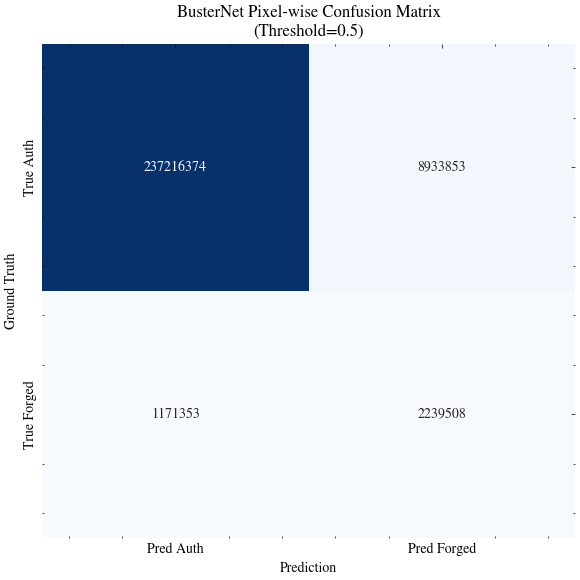

In [32]:
# Run evaluation
of1_score, solution_df, submission_df = evaluate_with_official_metric(
    model, device, thresh=0.5
)

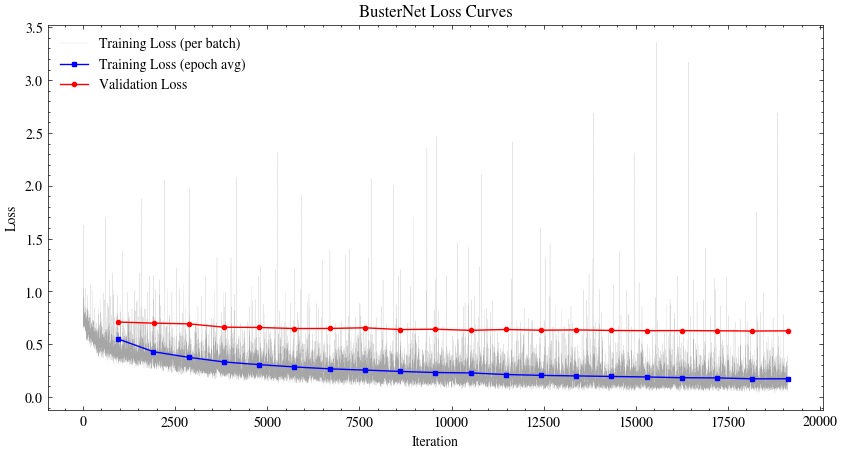

In [35]:
csv_path = model_path + "/training_loss_newdata.csv"
import pandas as pd
import matplotlib.pyplot as plt

val_losses = [
    (956, 0.7096),      # Epoch 1
    (1912, 0.6992),     # Epoch 2
    (2868, 0.6925),     # Epoch 3
    (3824, 0.6608),     # Epoch 4
    (4780, 0.6582),     # Epoch 5
    (5736, 0.6480),     # Epoch 6
    (6692, 0.6490),     # Epoch 7
    (7648, 0.6552),     # Epoch 8
    (8604, 0.6384),     # Epoch 9
    (9560, 0.6414),     # Epoch 10
    (10516, 0.6311),    # Epoch 11
    (11472, 0.6390),    # Epoch 12
    (12428, 0.6322),    # Epoch 13
    (13384, 0.6352),    # Epoch 14
    (14340, 0.6299),    # Epoch 15
    (15296, 0.6278),    # Epoch 16
    (16252, 0.6286),    # Epoch 17
    (17208, 0.6269),    # Epoch 18
    (18164, 0.6246),    # Epoch 19
    (19120, 0.6262),    # Epoch 20
]

df = pd.read_csv(csv_path, names=["epoch", "iteration", "loss"])

# Calculate average training loss per epoch
epoch_train_losses = []
for epoch_num in range(20):
    epoch_mask = df["epoch"] == epoch_num
    if epoch_mask.any():
        avg_loss = df.loc[epoch_mask, "loss"].mean()
        # Use the last iteration of each epoch as x-coordinate
        last_iter = df.loc[epoch_mask, "iteration"].max()
        epoch_train_losses.append((last_iter, avg_loss))

train_iters, train_vals = zip(*epoch_train_losses)

# Unpack validation losses into separate lists
val_iters, val_vals = zip(*val_losses)

plt.figure(figsize=(10, 5))
plt.plot(df["iteration"], df["loss"], label="Training Loss (per batch)", color="gray", linewidth=0.1, alpha=0.7)
plt.plot(train_iters, train_vals, label="Training Loss (epoch avg)", color="blue", linewidth=1, marker='s', markersize=3, zorder=5)
plt.plot(val_iters, val_vals, label="Validation Loss", color="red", linewidth=1, marker='o', markersize=3, zorder=5)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("BusterNet Loss Curves")
plt.legend()
plt.savefig('busternet_losscurve_new.pdf', bbox_inches='tight', dpi=300)
plt.show()


🔍 Visualizing Validation Samples...


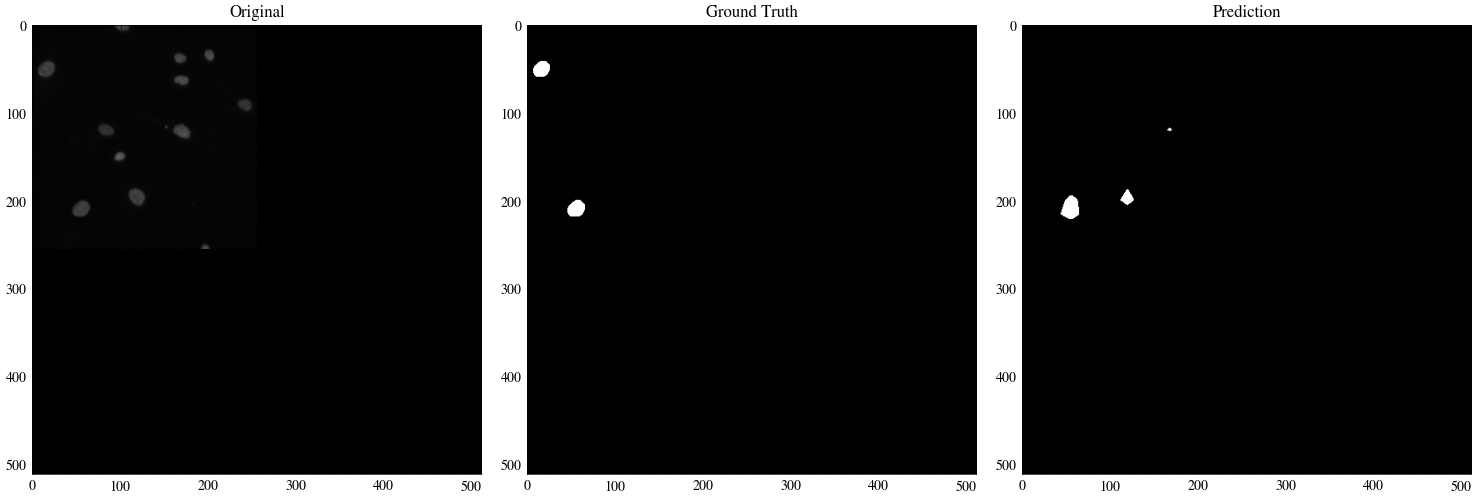

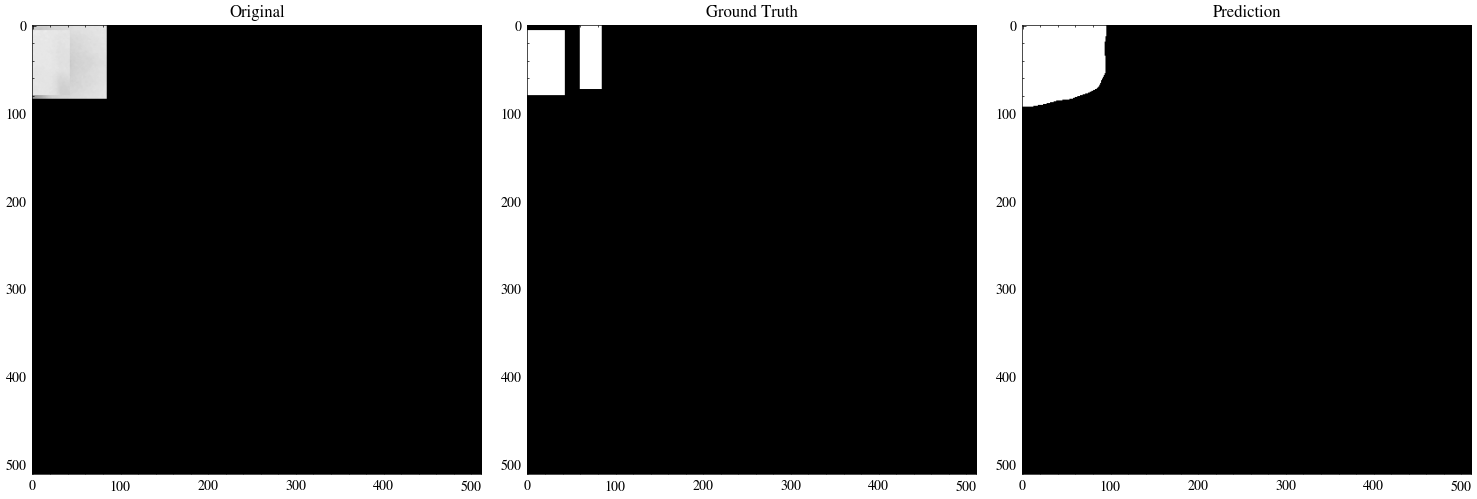

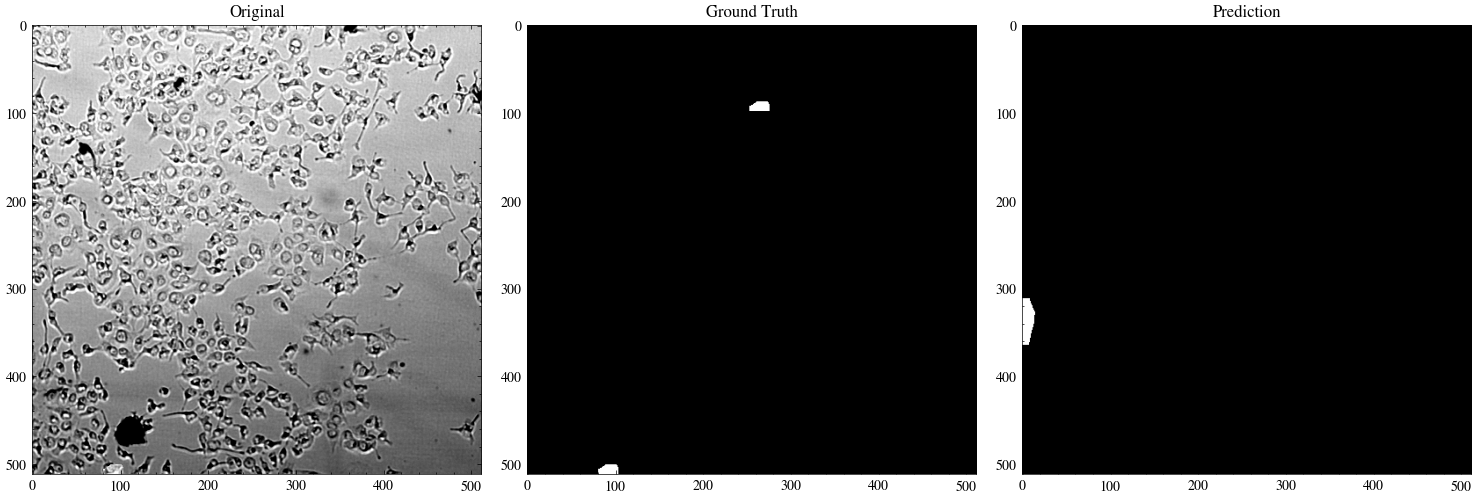

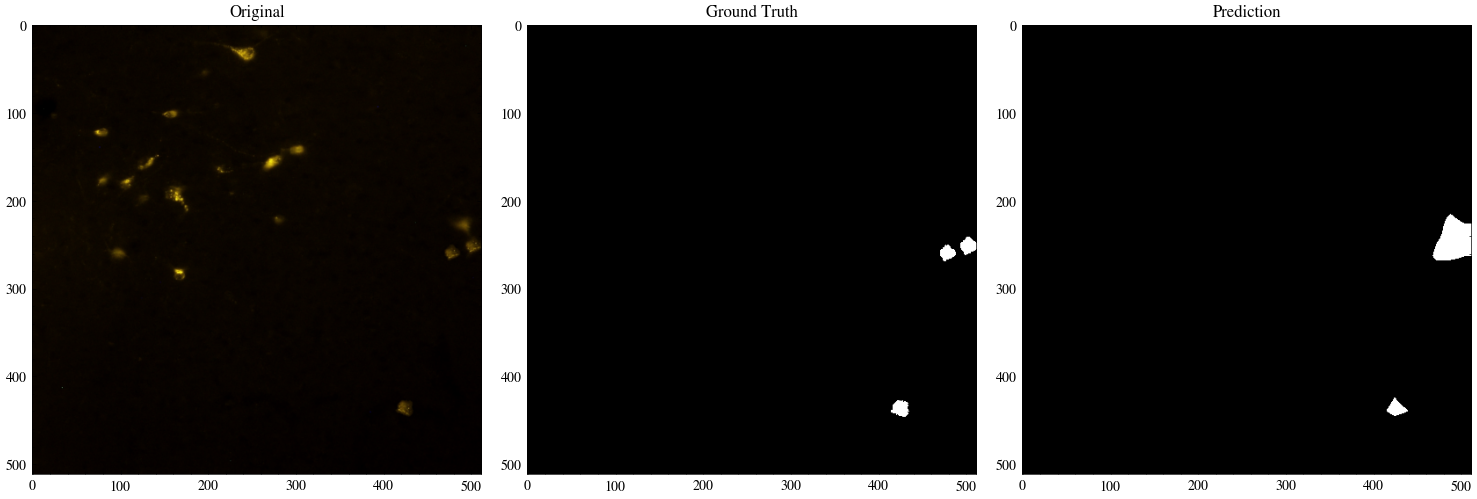

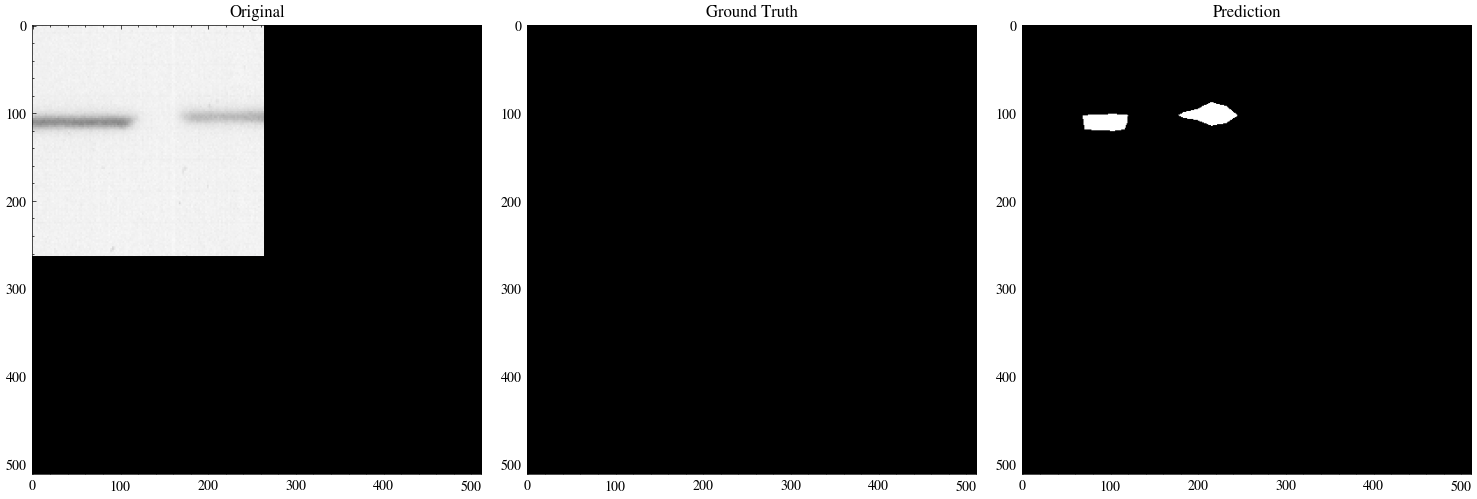

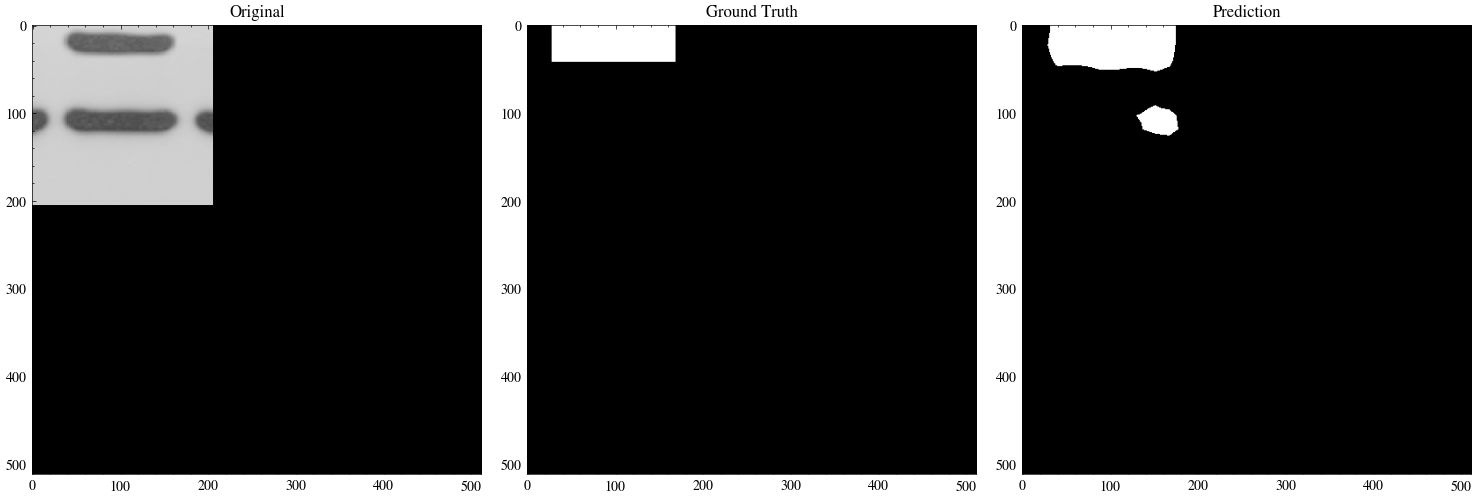

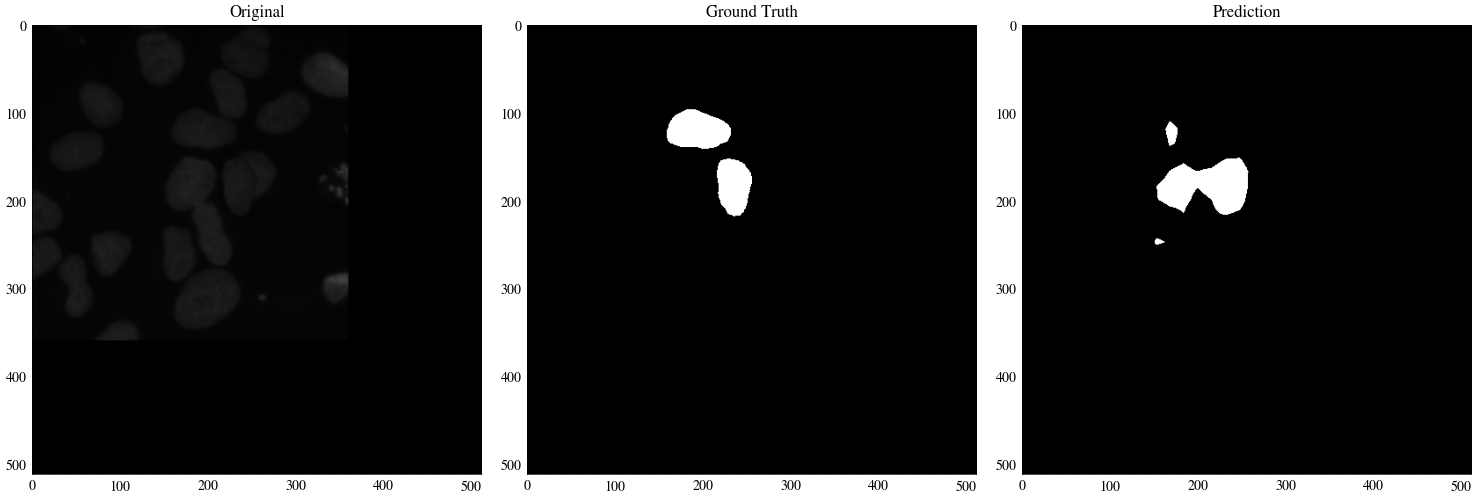

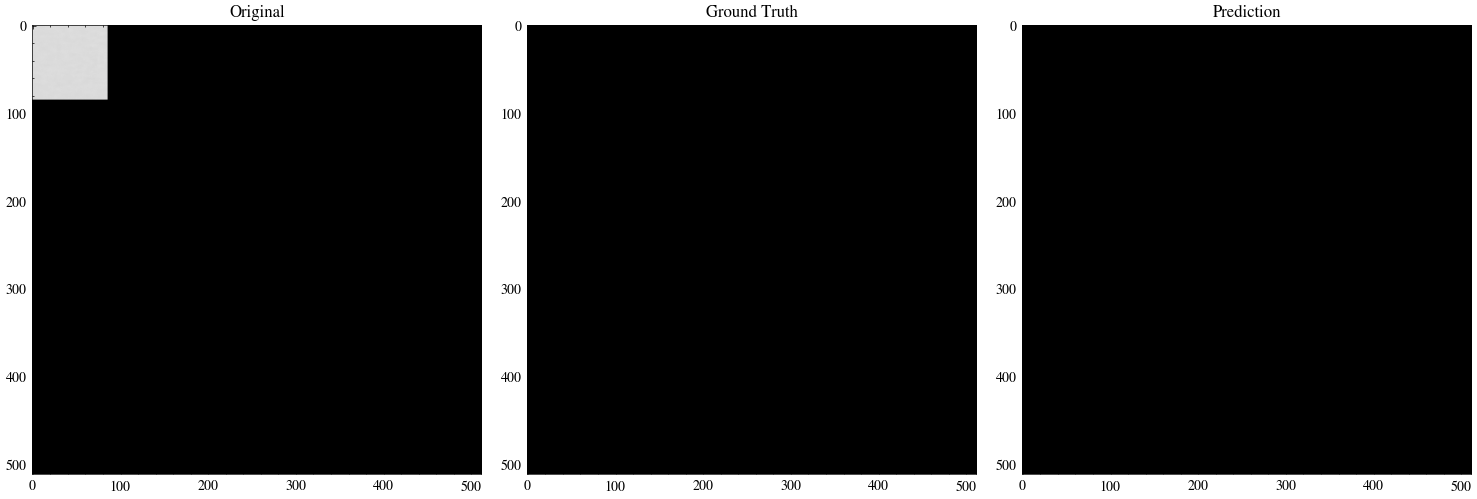

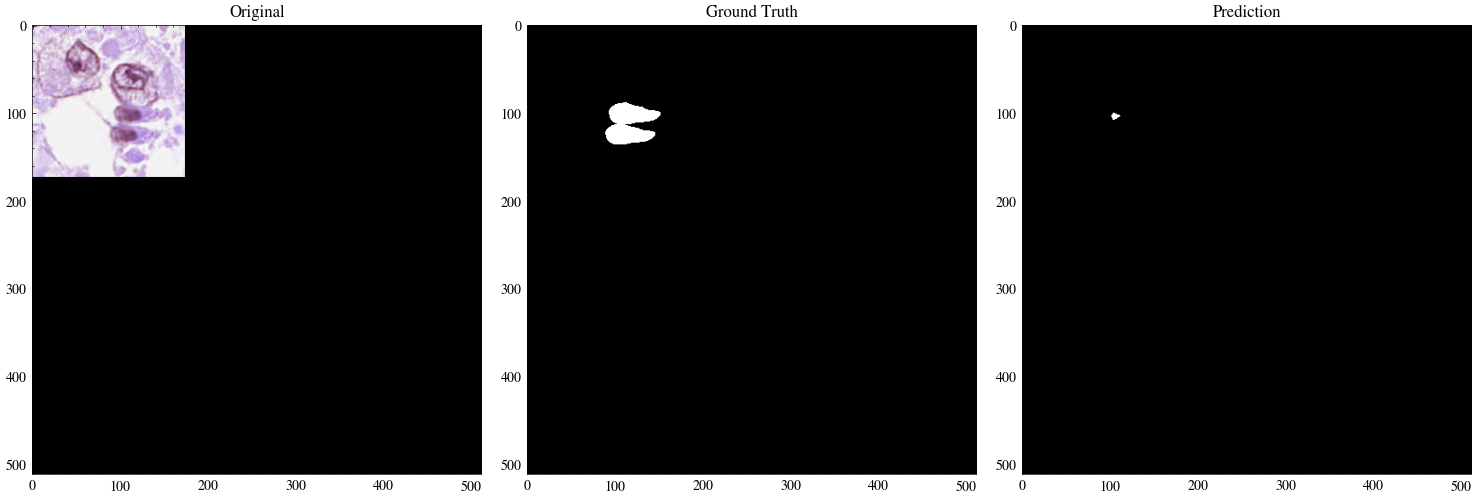

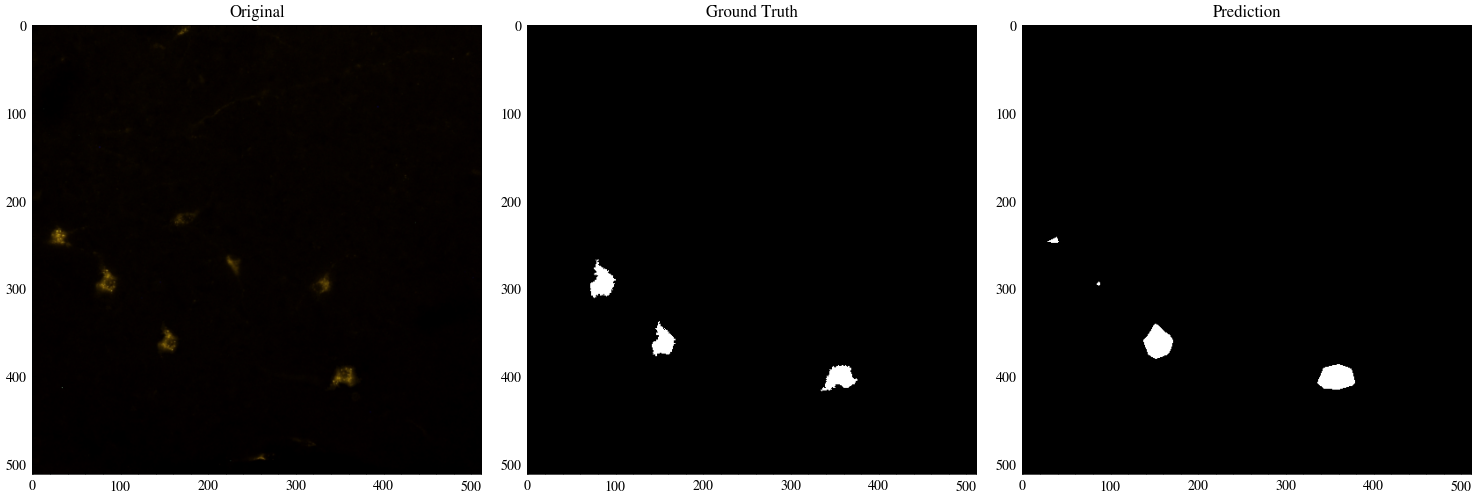

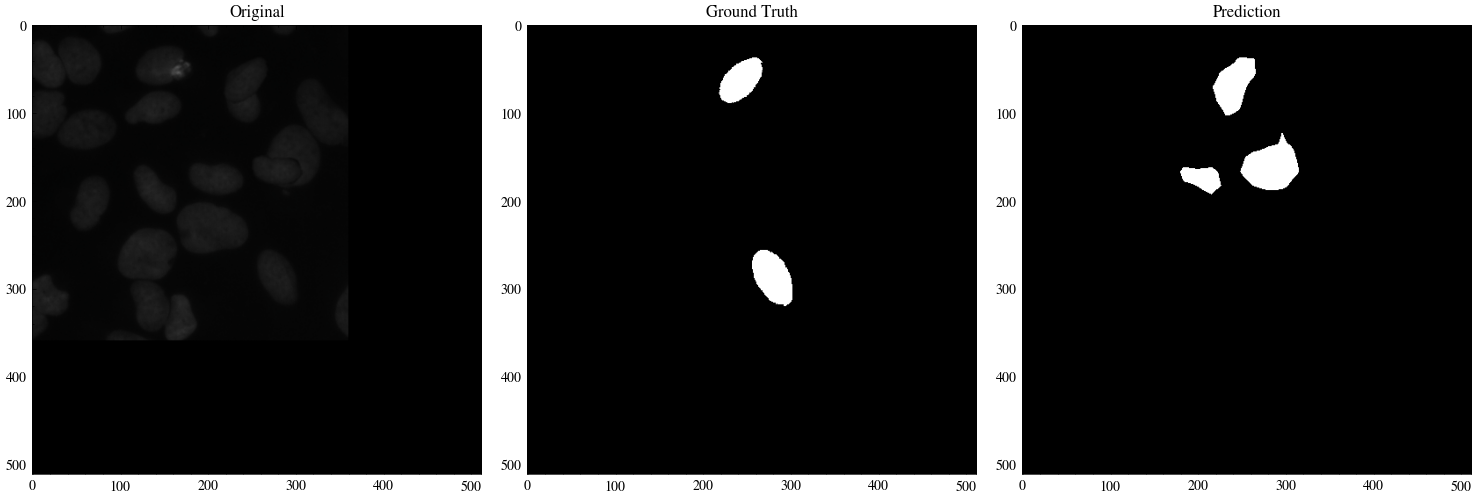

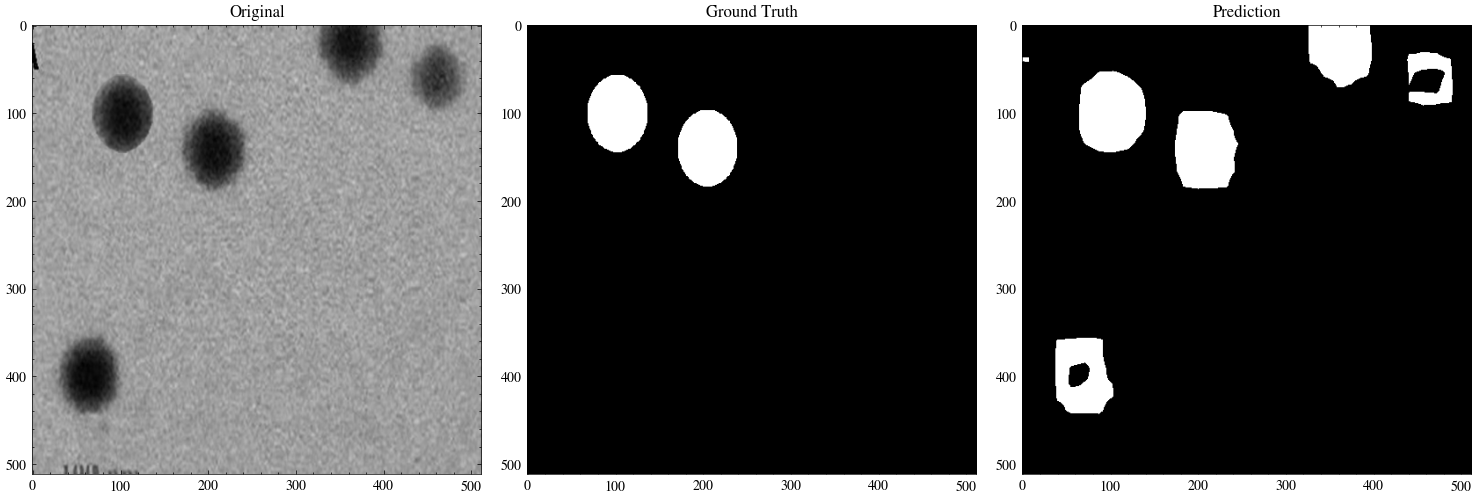

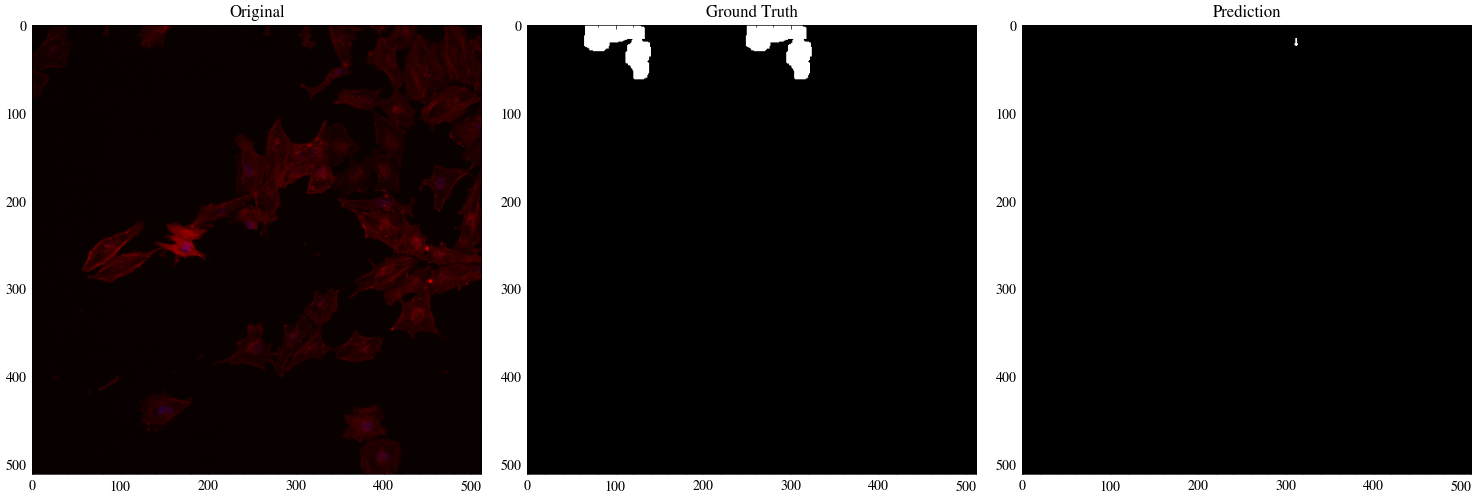

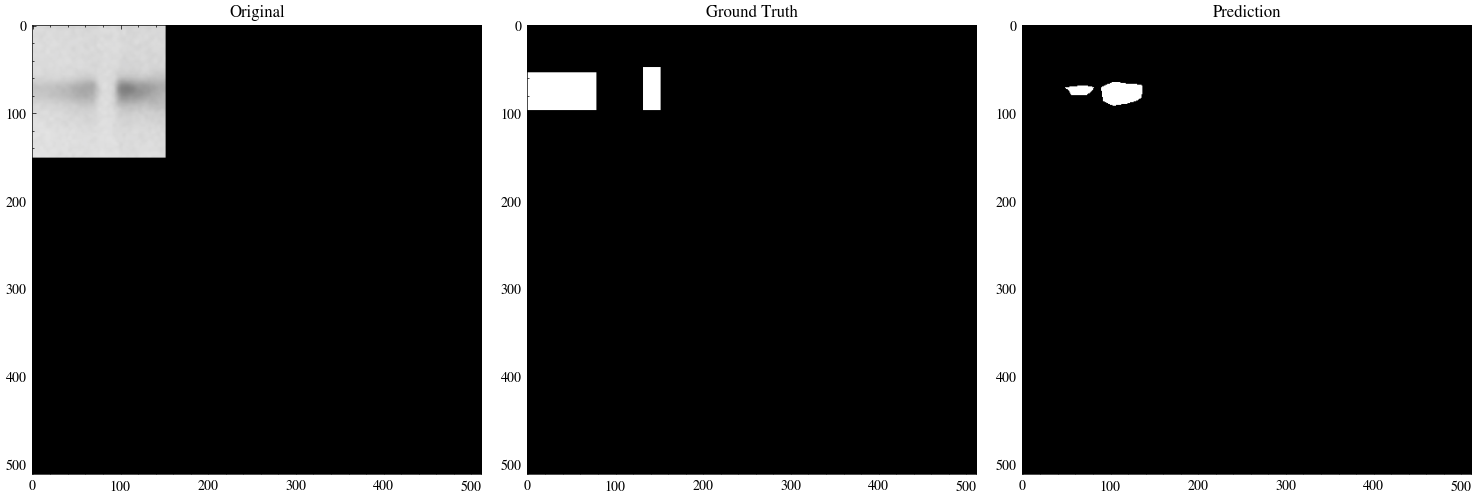

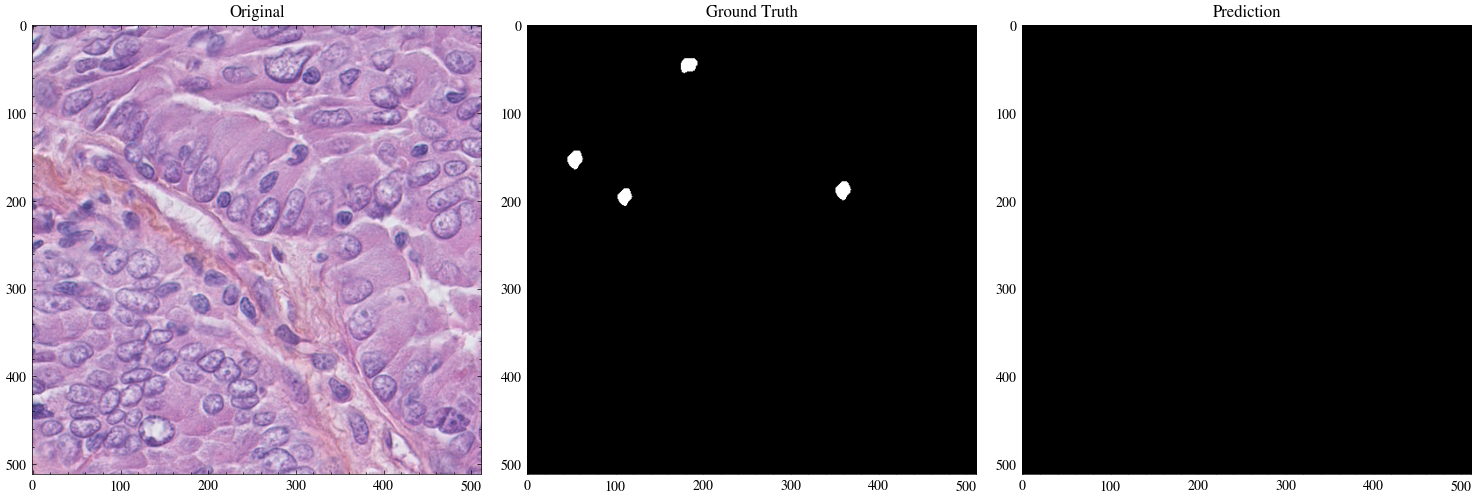

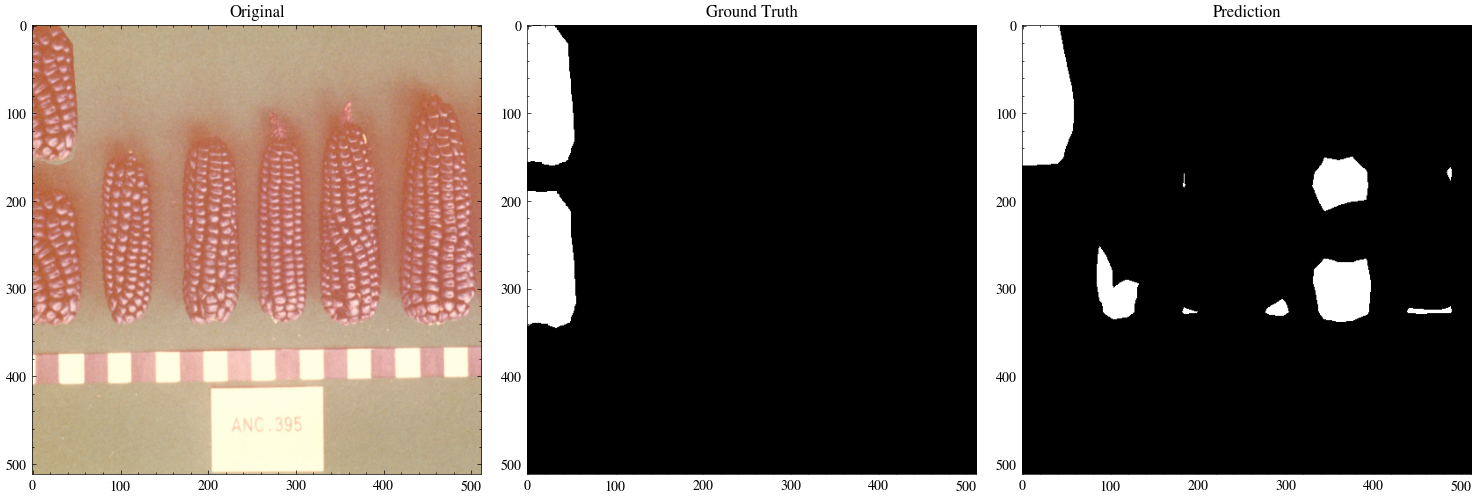

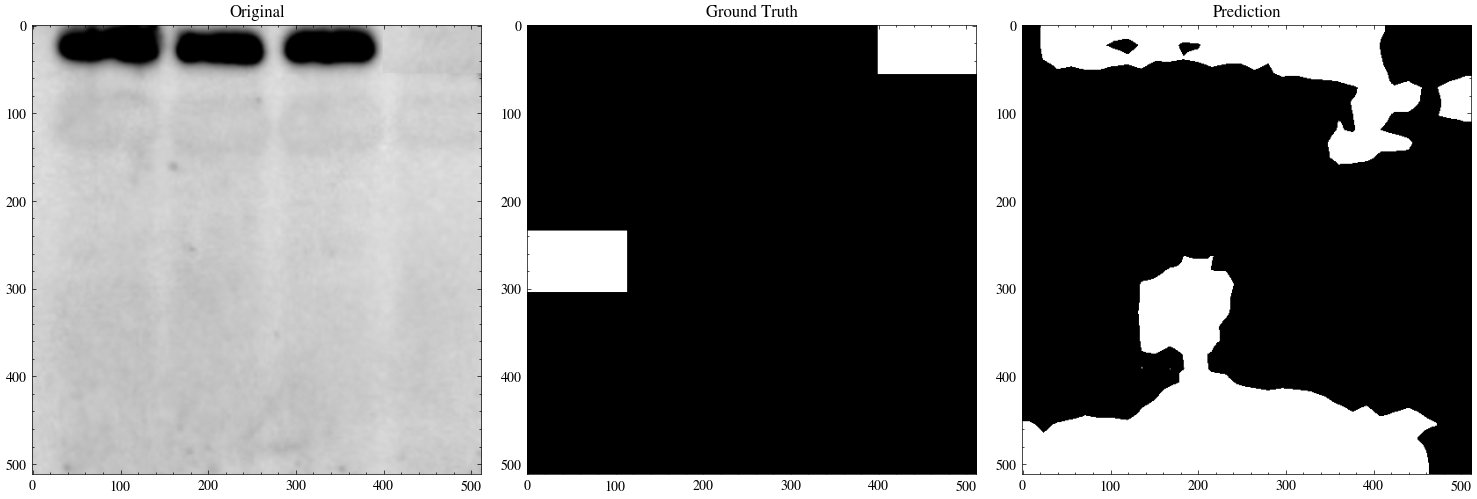

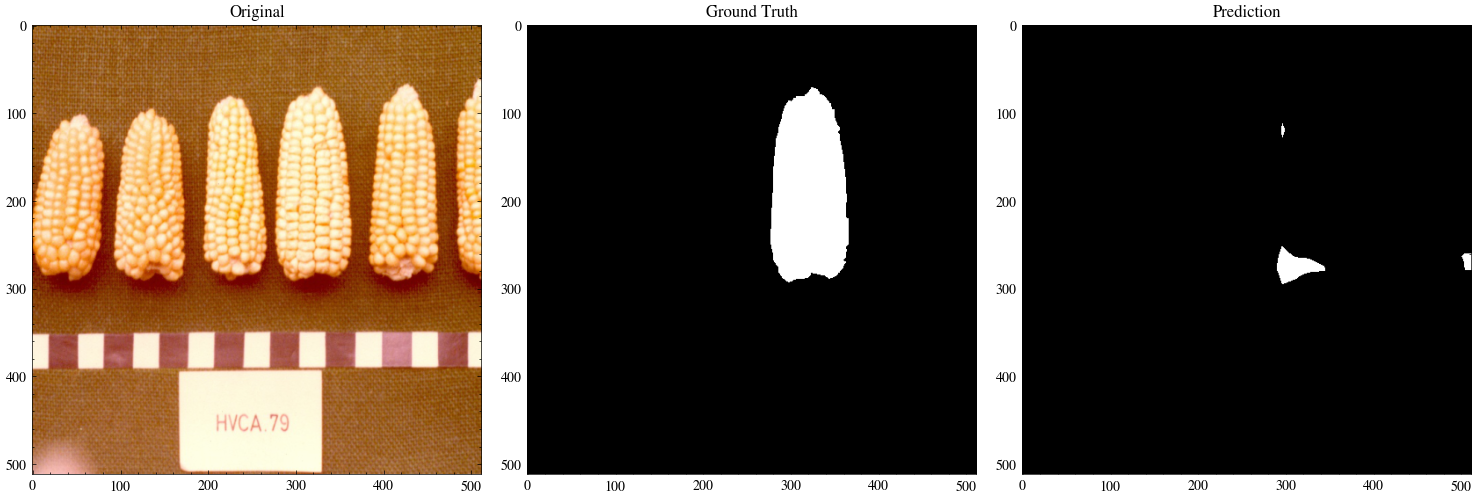

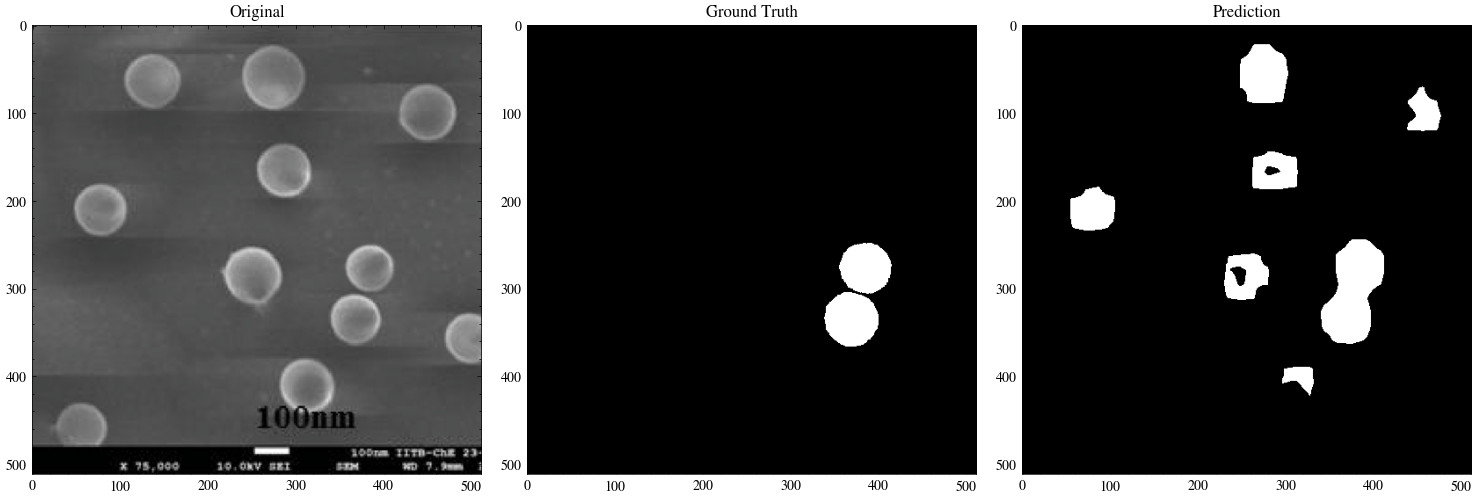

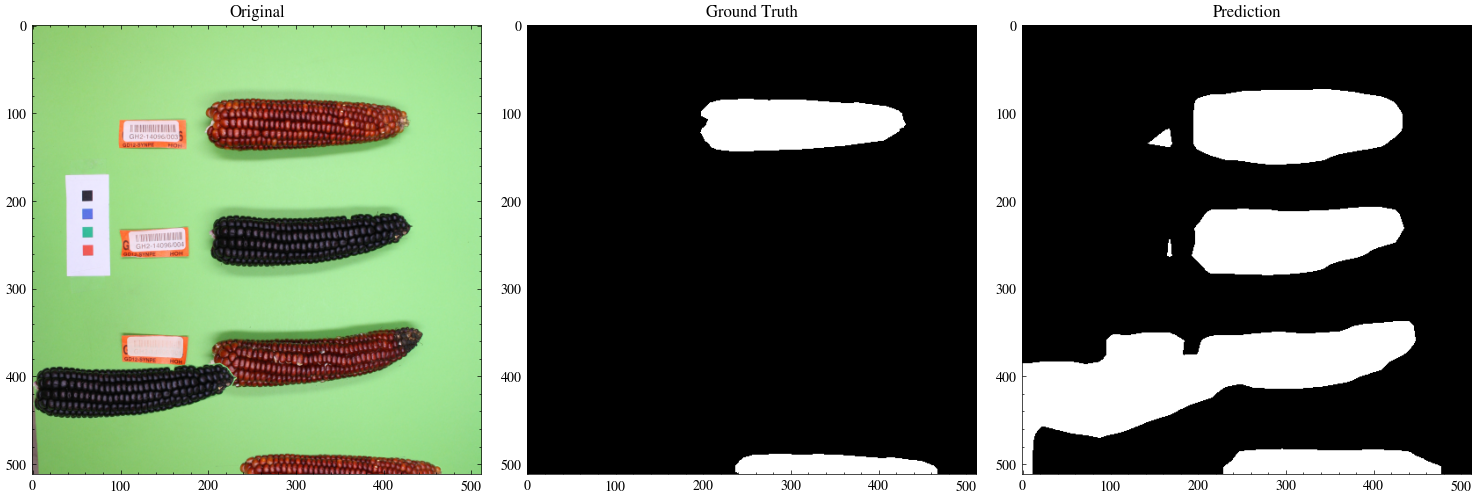

In [ ]:
print("\n🔍 Visualizing Validation Samples...")

# Get a few batches from validation
val_iter = iter(zip(loaders['val_f'], loaders['val_a']))

for batch_num in range(30,40):  # Show 3 batches
    (images_f, masks_f), (images_a, masks_a) = next(val_iter)
    
    # Show first image from each class
    for img_idx in range(2):  # 2 samples per batch
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Denormalize image for display
        img = images_f[img_idx].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = (img * std + mean).clip(0, 1)
        
        # Get prediction
        with torch.no_grad():
            pred = model(images_f[img_idx:img_idx+1].to(device))
            pred_mask = (torch.sigmoid(pred) > 0.5).cpu().numpy()[0, 0]
        
        gt_mask = masks_f[img_idx, 0].cpu().numpy()
        
        axes[0].imshow(img)
        axes[0].set_title("Original")
        axes[1].imshow(gt_mask, cmap='gray')
        axes[1].set_title("Ground Truth")
        axes[2].imshow(pred_mask, cmap='gray')
        axes[2].set_title("Prediction")
        
        plt.tight_layout()
        plt.show()

In [43]:
class VisualizationDataset(Dataset):
    """Simple dataset for visualization - loads full images without patches"""
    def __init__(self, root_dir, img_size=512):
        self.root_dir = Path(root_dir)
        self.img_size = img_size
        
        # Get validation images
        val_path = self.root_dir / "data_patches" / "val"
        self.forged_paths = sorted(list((val_path / "forged").glob("*")))
        self.authentic_paths = sorted(list((val_path / "authentic").glob("*")))
        self.all_paths = self.forged_paths + self.authentic_paths
        
        # Build curriculum_meta for compatibility
        self.curriculum_meta = []
        for idx, img_path in enumerate(self.all_paths):
            area = 0
            if "forged" in str(img_path):
                mask_path = val_path / "masks" / (img_path.stem + ".npy")
                if mask_path.exists():
                    mask = np.load(mask_path)
                    if mask.ndim == 3:
                        mask = mask[0]
                    area = np.sum(mask > 0)
            self.curriculum_meta.append((idx, 0, area))
    
    def __len__(self):
        return len(self.all_paths)
    
    def __getitem__(self, idx):
        img_path = self.all_paths[idx]
        is_forged = "forged" in str(img_path)
        
        # Load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load mask
        mask = None
        if is_forged:
            mask_path = self.root_dir / "data_patches" / "val" / "masks" / (img_path.stem + ".npy")
            if mask_path.exists():
                mask = np.load(mask_path)
                if mask.ndim == 3:
                    mask = mask[0]
        
        # Use the same preprocessing as validation
        import preprocess
        img_processed, mask_processed = preprocess.process_val_image(
            img, mask, target_size=self.img_size
        )
        
        # Convert to tensor (match training format)
        img_tensor = torch.from_numpy(img_processed.astype(np.float32) / 255.0).permute(2, 0, 1)
        
        if mask_processed is not None:
            mask_tensor = torch.from_numpy(mask_processed > 0).float().unsqueeze(0)
        else:
            mask_tensor = torch.zeros(1, self.img_size, self.img_size)
        
        return img_tensor, mask_tensor


🔍 Inspecting Model Performance on Validation Set...
Found 220 images with large forgeries
--- Example 1 (Index 0, Area: 597145) ---


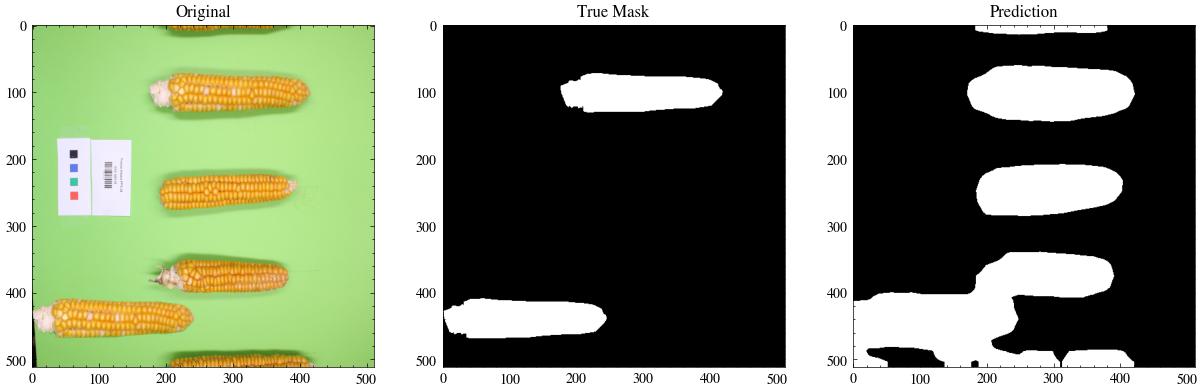

--- Example 2 (Index 1, Area: 13306) ---


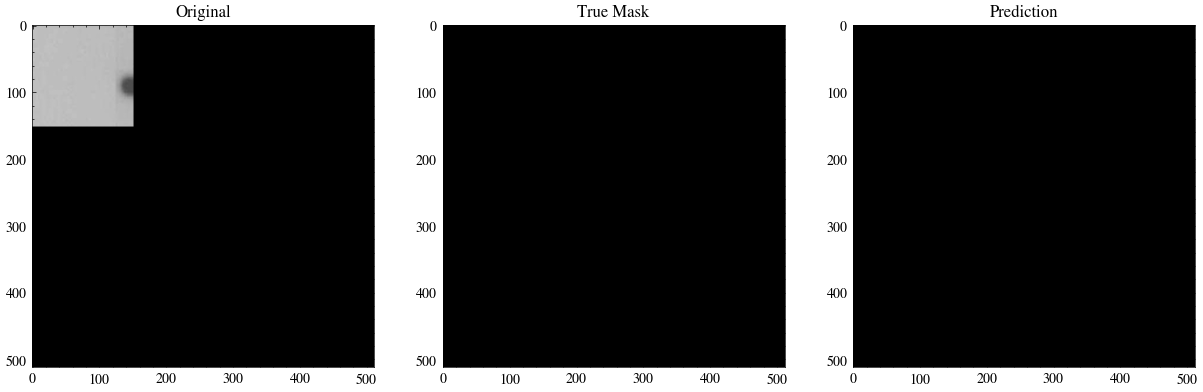

--- Example 3 (Index 2, Area: 51701) ---


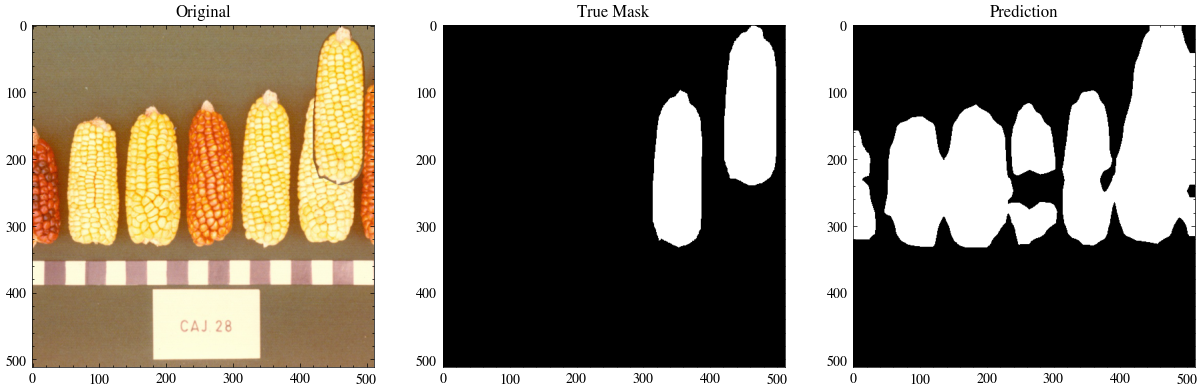

--- Example 4 (Index 7, Area: 579887) ---


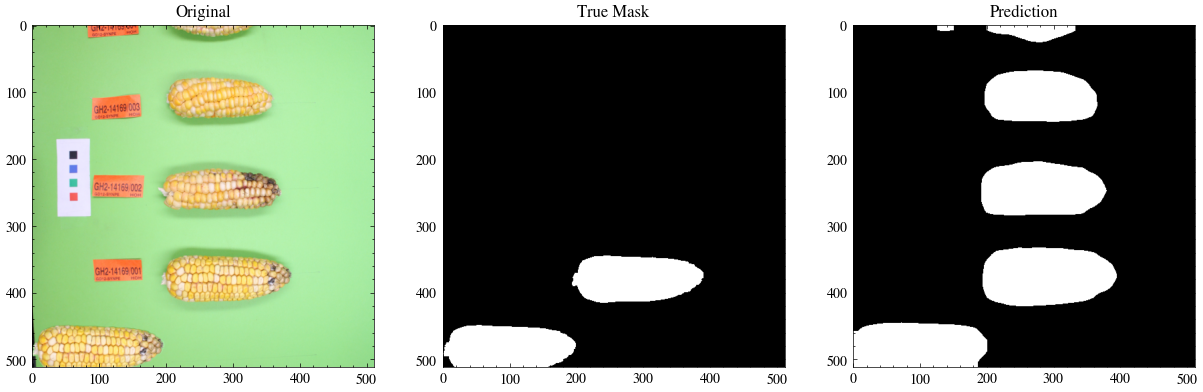

--- Example 5 (Index 12, Area: 12338) ---


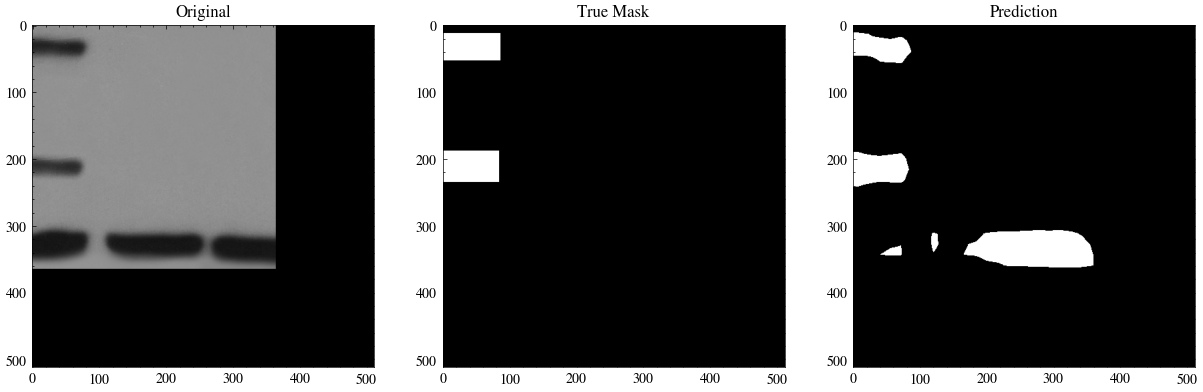

--- Example 6 (Index 13, Area: 17562) ---


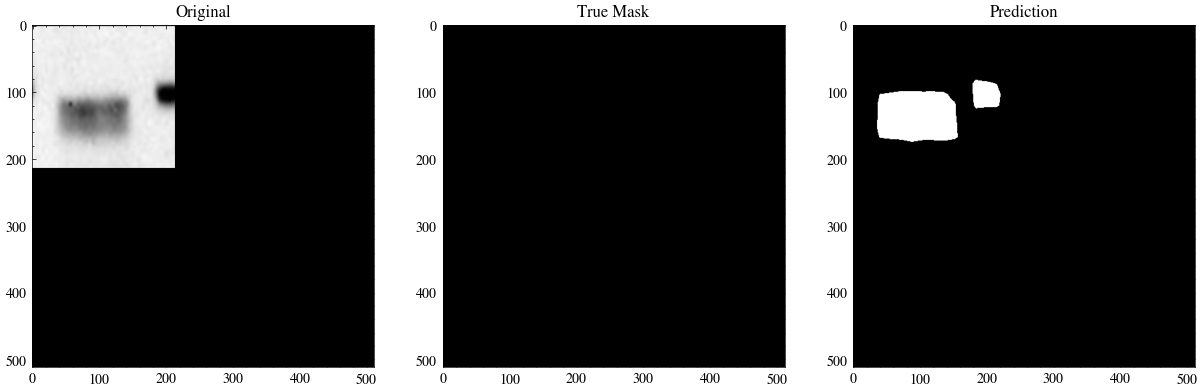

--- Example 7 (Index 14, Area: 10007) ---


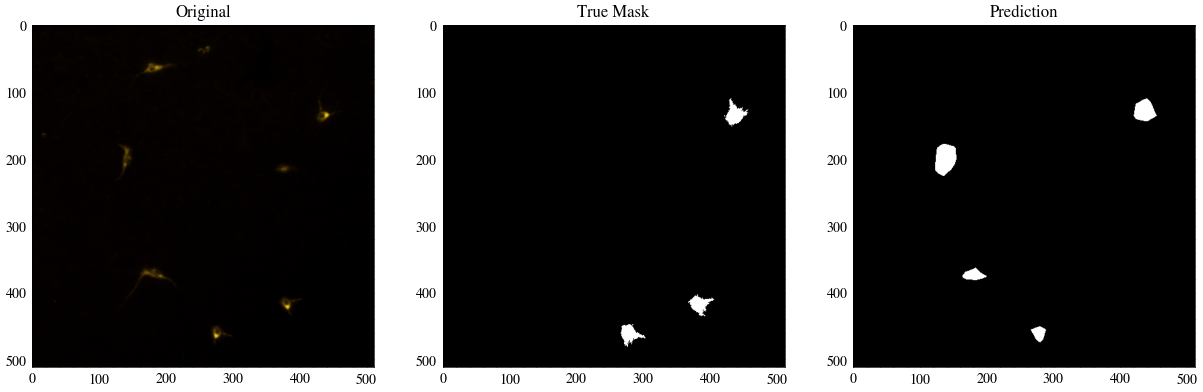

--- Example 8 (Index 18, Area: 32099) ---


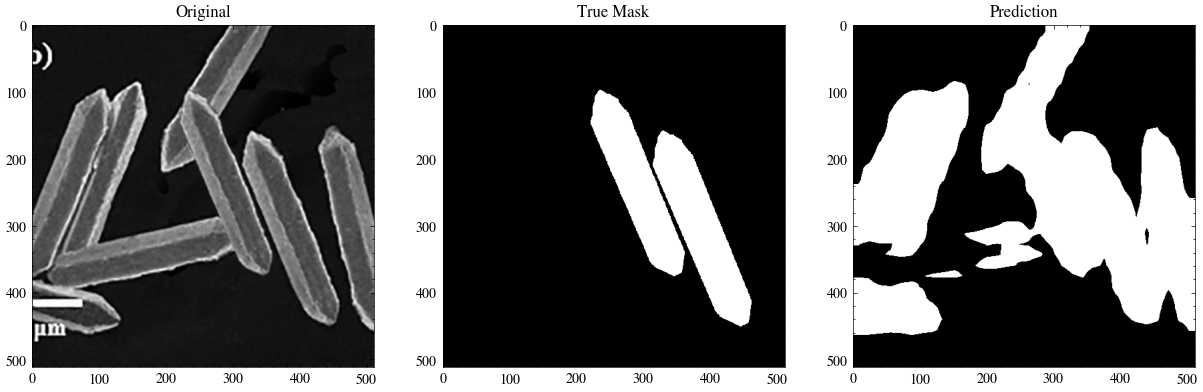

--- Example 9 (Index 20, Area: 318797) ---


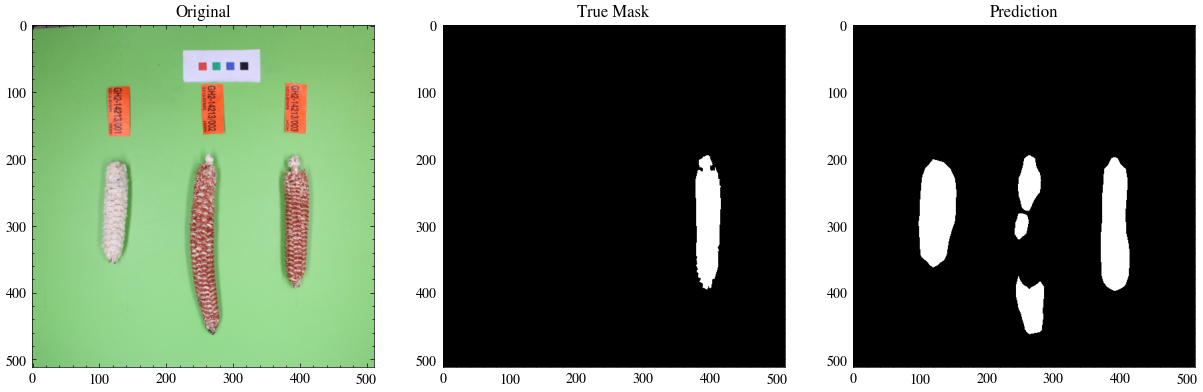

--- Example 10 (Index 22, Area: 410997) ---


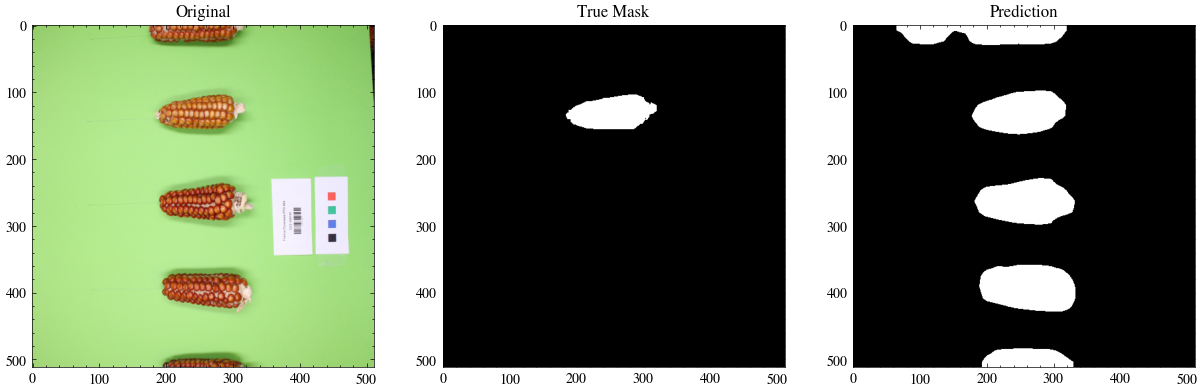

In [44]:
# Visualize Specific Indices

print("\n🔍 Inspecting Model Performance on Validation Set...")

# Create visualization dataset
base_path = "/Users/chelsymena/recodai-luc-scientific-image-forgery-detection"
vis_dataset = VisualizationDataset(root_dir=base_path, img_size=512)

# Helper to find indices of big forgeries for demo
all_meta = vis_dataset.curriculum_meta
big_forgeries = [x[0] for x in all_meta if x[2] > 10000]

print(f"Found {len(big_forgeries)} images with large forgeries")

# Visualize random big forgeries
for i in range(min(10, len(big_forgeries))):  # Show up to 10 samples
    idx = big_forgeries[i]
    print(f"--- Example {i+1} (Index {idx}, Area: {all_meta[idx][2]}) ---")
    visualize_prediction(model, vis_dataset, device, index=idx)

## Validation on Patched Images

In [49]:
# --- THE PATCH RETRIEVER ---
import preprocess_fullpatch as preprocess

print("🚀 Starting patch extraction logic...")

base_path = "/Users/chelsymena/recodai-luc-scientific-image-forgery-detection"

train_metadata = preprocess.scan_and_visualize_train(
    root_dir= Path(base_path) / "data_fullpatches", 
    patch_size=512, 
    target_limit=20000,
)

all_f, all_a = train_metadata['forged'], train_metadata['authentic']

# Validation Patches (using the same scanning logic)
val_metadata = preprocess.scan_and_visualize_val(
    root_dir=Path(base_path) / "data_fullpatches",
    patch_size=512
)

val_f = val_metadata['forged']
val_a = val_metadata['authentic']

# Augmentations
train_trans = A.Compose([A.HorizontalFlip(p=0.5), A.RandomRotate90(p=0.5), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])
val_trans = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])

# Dataloaders
half = 8 // 2
loaders = {
    'train_f': DataLoader(LeanDataset(all_f, 'train', train_trans), batch_size=half, shuffle=True),
    'train_a': DataLoader(LeanDataset(all_a, 'train', train_trans), batch_size=half, shuffle=True),
    'val_f': DataLoader(LeanDataset(val_f, 'train', val_trans), batch_size=half, shuffle=False),  # Changed to 'train' split_type
    'val_a': DataLoader(LeanDataset(val_a, 'train', val_trans), batch_size=half, shuffle=False)   # Changed to 'train' split_type
}

print(f"✅ Setup Complete! Training on {len(all_f)} Forged / {len(all_a)} Auth patches.")
print(f"✅ Validation on {len(val_f)} Forged / {len(val_a)} Auth patches.")

🚀 Starting patch extraction logic...

🔍 Scanning TRAIN patches (Size: 512)...


Scanning train authentic: 100%|██████████| 1901/1901 [00:22<00:00, 84.87it/s] 


📊 TRAIN COUNTS: Forged: 4227, Auth: 3824

🔍 Scanning VAL patches (Size: 512)...


Scanning val authentic: 100%|██████████| 476/476 [00:06<00:00, 77.27it/s] 

📊 VAL COUNTS: Forged: 1117, Auth: 1032
✅ Setup Complete! Training on 4227 Forged / 3824 Auth patches.
✅ Validation on 1117 Forged / 1032 Auth patches.


Evaluating: 258it [02:09,  1.99it/s]



🏆 EVALUATION RESULTS:
   Official Competition Metric (oF1): 0.4358
   Pixel-wise F1:                     0.6164
   Pixel Precision:                   0.4784
   Pixel Recall:                      0.8663
   Confusion Matrix: 
[[501527282  19205705]
 [  2719330  17612899]]


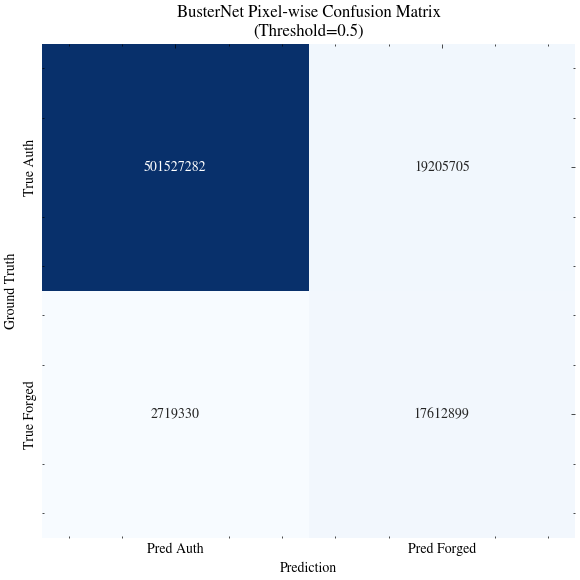

In [50]:
of1_score, solution_df, submission_df = evaluate_with_official_metric(
    model, device, thresh=0.5
)

In [ ]:
# plot some of the images in the validation set
val_iter = iter(zip(loaders['val_f'], loaders['val_a']))

for batch_num in range(3):  # Show 3 batches
    (images_f, masks_f), (images_a, masks_a) = next(val_iter)
    
    # Show first image from each class
    for img_idx in range(2):  # 2 samples per batch
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Denormalize image for display
        img = images_f[img_idx].cpu().numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = (img * std + mean).clip(0, 1)
        
        # Get prediction
        with torch.no_grad():
            pred = model(images_f[img_idx:img_idx+1].to(device))
            pred_mask = (torch.sigmoid(pred) > 0.5).cpu().numpy()[0, 0]
        
        gt_mask = masks_f[img_idx, 0].cpu().numpy()
        
        axes[0].imshow(img)
        axes[0].set_title("Original")
        axes[1].imshow(gt_mask, cmap='gray')
        axes[1].set_title("Ground Truth")
        axes[2].imshow(pred_mask, cmap='gray')
        axes[2].set_title("Prediction")
        
        plt.tight_layout()
        plt.show()

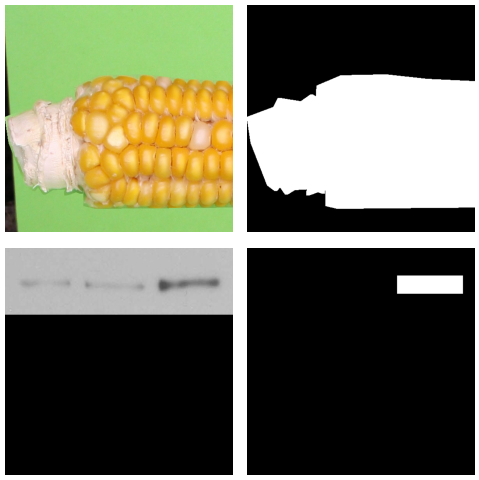

In [58]:
# Plot specific validation patches
val_iter = iter(zip(loaders['val_f'], loaders['val_a']))

# Get batch 1
batch1 = next(val_iter)
batch1 = next(val_iter)
(images_f_b1, masks_f_b1), _ = batch1

# Get batch 2
batch2 = next(val_iter)
(images_f_b2, masks_f_b2), _ = batch2

# Create 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

# Batch 1, Forged Image 1 (index 0)
img1 = images_f_b1[1].cpu().numpy().transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img1 = (img1 * std + mean).clip(0, 1)
mask1 = masks_f_b1[1, 0].cpu().numpy()

axes[0, 0].imshow(img1)
axes[0, 0].axis('off')
axes[0, 1].imshow(mask1, cmap='gray')
axes[0, 1].axis('off')

# Batch 2, Forged Image 0
img2 = images_f_b2[0].cpu().numpy().transpose(1, 2, 0)
img2 = (img2 * std + mean).clip(0, 1)
mask2 = masks_f_b2[0, 0].cpu().numpy()

axes[1, 0].imshow(img2)
axes[1, 0].axis('off')
axes[1, 1].imshow(mask2, cmap='gray')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('patches.pdf', bbox_inches='tight', dpi=300)
plt.show()

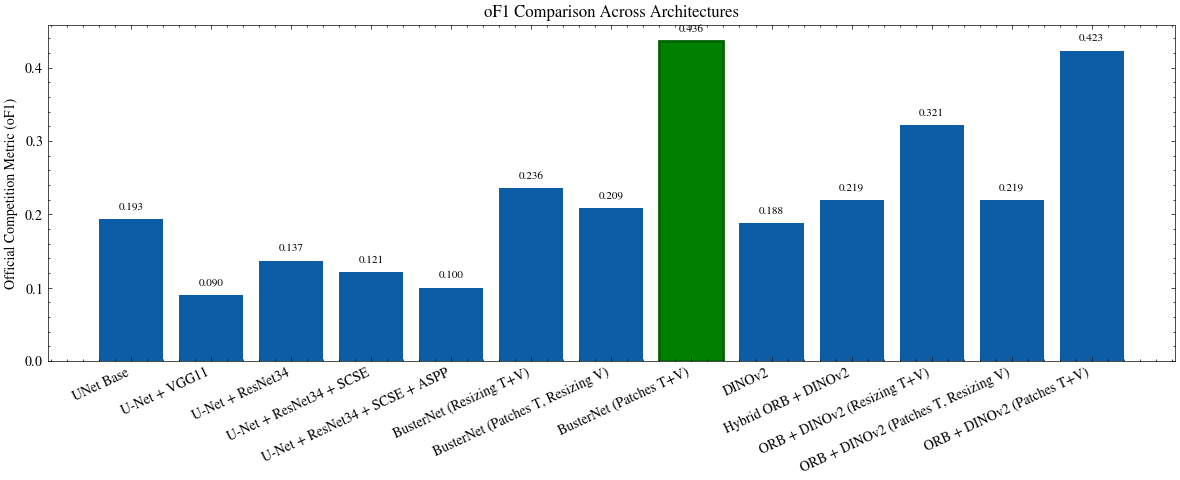

In [68]:
methods = [
    "UNet Base",
    "U-Net + VGG11",
    "U-Net + ResNet34",
    "U-Net + ResNet34 + SCSE",
    "U-Net + ResNet34 + SCSE + ASPP",
    "BusterNet (Resizing T+V)",
    "BusterNet (Patches T, Resizing V)",
    "BusterNet (Patches T+V)",
    "DINOv2",
    "Hybrid ORB + DINOv2",
    "ORB + DINOv2 (Resizing T+V)",
    "ORB + DINOv2 (Patches T, Resizing V)",
    "ORB + DINOv2 (Patches T+V)",
]

of1 = [
    0.1934,
    0.0901,
    0.1367,
    0.1215,
    0.0999,
    0.2360,
    0.2089,
    0.4358,
    0.1878,
    0.2191,
    0.3212,
    0.2191,
    0.4229,
]


import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(methods))
best_idx = np.argmax(of1)

plt.figure(figsize=(12, 5))
bars = plt.bar(x, of1)

# Highlight best method
bars[best_idx].set_color("green")
bars[best_idx].set_edgecolor("darkgreen")
bars[best_idx].set_linewidth(2)

# Annotate values
for i, v in enumerate(of1):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=8)

plt.xticks(x, methods, rotation=25, ha="right")
plt.ylabel("Official Competition Metric (oF1)")
plt.title("oF1 Comparison Across Architectures")
plt.tight_layout()
plt.savefig('of1_comparison.pdf', bbox_inches='tight', dpi=300)
plt.show()
